In [158]:
import os
import sys
import re
from pathlib import Path
from collections import namedtuple
from yaml import load

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.io import cellranger_umi

In [3]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-11-07 
Git hash:


In [179]:
raw = nbconfig.seurat.get_raw()

In [180]:
fbgns = list(map(lambda x: nbconfig.symbol2fbgn[x], ['bam', 'tj']))
_raw = raw.loc[fbgns]
dups = _raw.columns[(_raw.loc[fbgns] > 0).all()].tolist()

In [181]:
rep1 = dups[:11]
rep2 = dups[11:43]
rep3 = dups[43:]

In [182]:
len(rep1), len(rep2), len(rep3)

(11, 32, 21)

In [183]:
cluster_annot = {
    0: 'LS',
    1: 'MC',
    2: 'MS',
    3: 'ES',
    4: 'LC',
    5: 'EC',
    6: 'SP',
    7: 'TE',
    8: 'PC',
    9: 'U9',
    10: 'U10',
    11: 'U11'
}

cluster_order = [
    'SP',
    'ES',
    'MS',
    'LS',
    'EC',
    'MC',
    'LC',
    'TE',
    'PC',
    'U9',
    'U10',
    'U11'
]

In [184]:
clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters.map(cluster_annot)
clusters = pd.Series(pd.Categorical(clusters, categories=cluster_order, ordered=True), index=clusters.index)
clusters.name = 'cluster'

In [185]:
def munge(fname, rep):
    dat = cellranger_umi(fname).groupby('cell_id').size()
    dat.name = 'umi_count'
    dat.index = f'{rep}_' + dat.index.values
    dat = pd.concat([dat, clusters], axis=1, sort=True)
    dat.sort_values('umi_count', ascending=False, inplace=True)
    dat['cell_rank'] = range(1, dat.shape[0] + 1)
    dat['dups'] = False
    dat['dupFinder'] = False
    dat['scrublet'] = False
    
    with open(f'../output/notebook/2018-10-29_testing_doubletdetection_{rep}.txt') as fh:
        dups = fh.read().strip().split('\n')
        dat.loc[dups, 'dups'] = True
        
    with open(f'../output/notebook/2018-10-30_testing_doubletFinder_{rep}.txt') as fh:
        dups = fh.read().strip().split('\n')
        dat.loc[dups, 'dupFinder'] = True
        
    with open(f'../output/notebook/2018-11-01_testing_scrublet_{rep}.txt') as fh:
        dups = fh.read().strip().split('\n')
        dat.loc[dups, 'scrublet'] = True
    
    return dat

In [186]:
def plot_knee(dat, ax, title='All Cells', **kwargs):
    args = dict(x='cell_rank', y='umi_count', s=10, alpha=.8, color='grey', ax=ax)
    args.update(kwargs)
    dat.plot.scatter(**args)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axhline(10**5, ls='--', color='red', lw=.8)
    ax.set_title(title, fontsize=8)
    
def plotall(dat, title):
    # figure layout
    fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
    # Plot all cells
    plot_knee(dat, ax, zorder=1)
    plot_knee(dat.loc[dups], ax, zorder=10, s=30, color='red', title=title)

# Bam and Tj

In [180]:
fbgns = list(map(lambda x: nbconfig.symbol2fbgn[x], ['bam', 'tj']))
_raw = raw.loc[fbgns]
dups = _raw.columns[(_raw.loc[fbgns] > 0).all()].tolist()

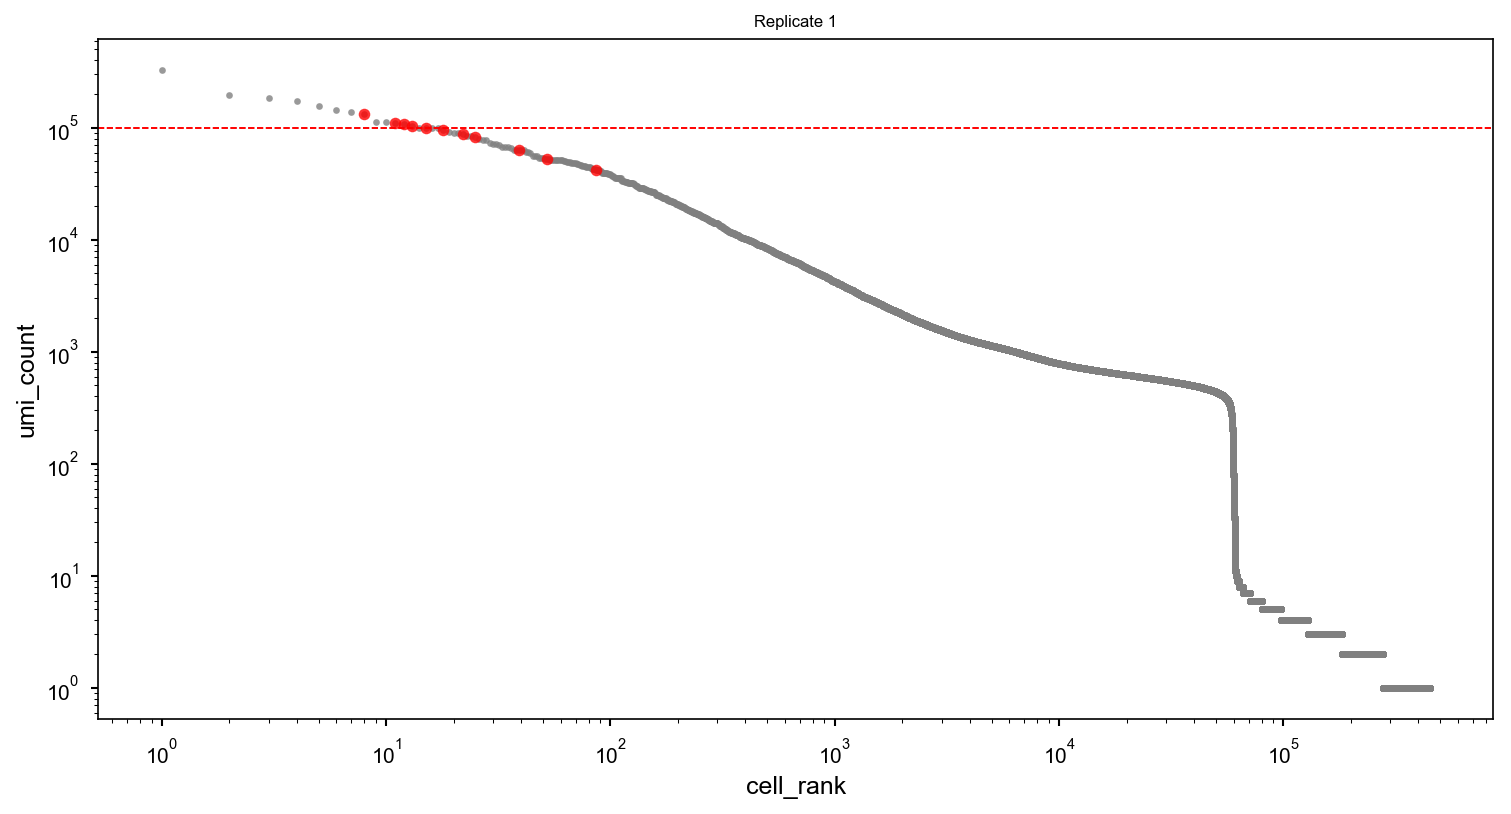

In [187]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis1_force/outs/molecule_info.h5', 'rep1')
plotall(dat, 'Replicate 1')

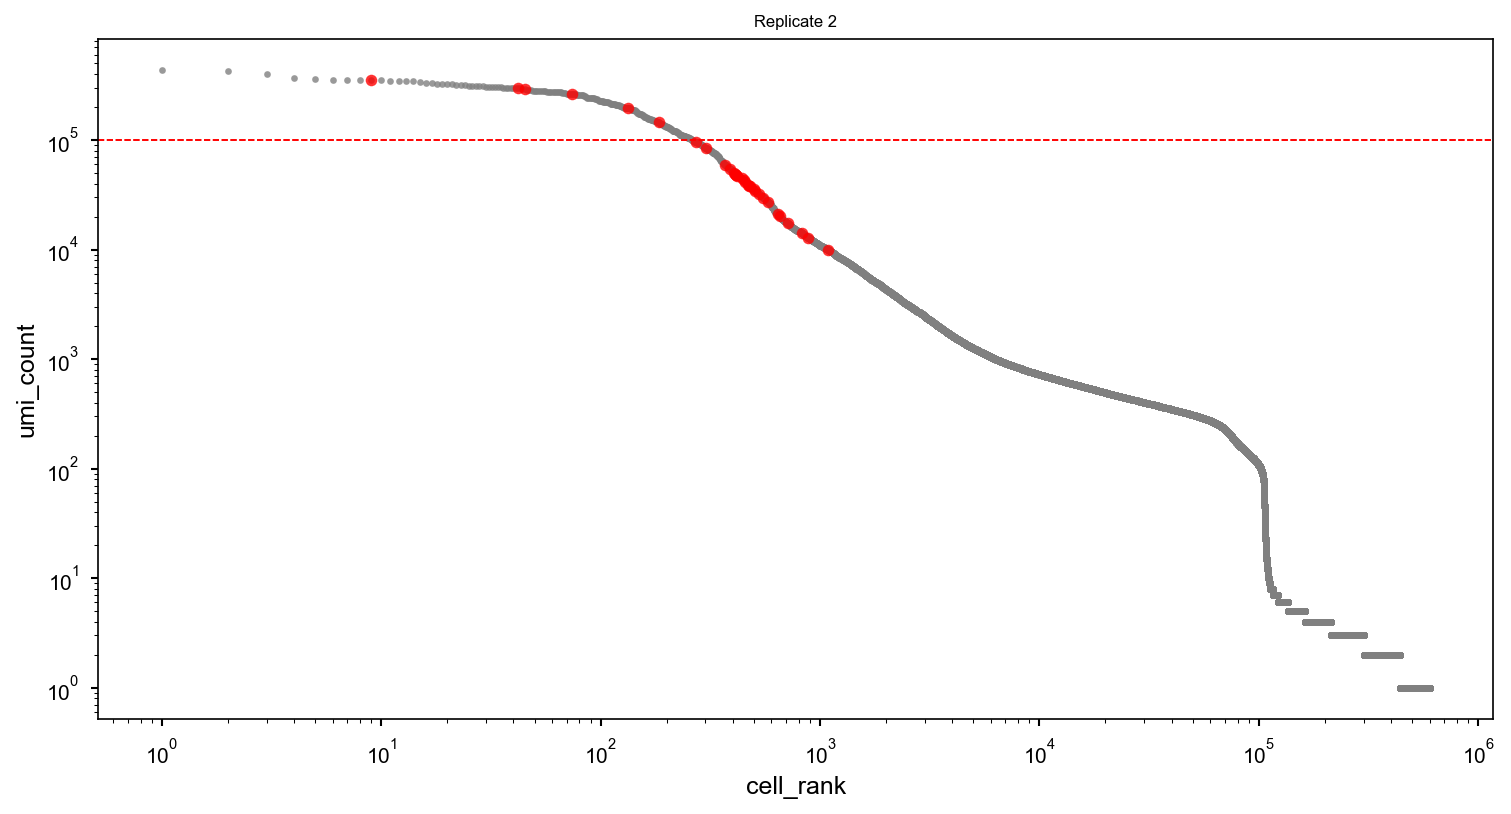

In [188]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis2_force/outs/molecule_info.h5', 'rep2')
plotall(dat, 'Replicate 2')

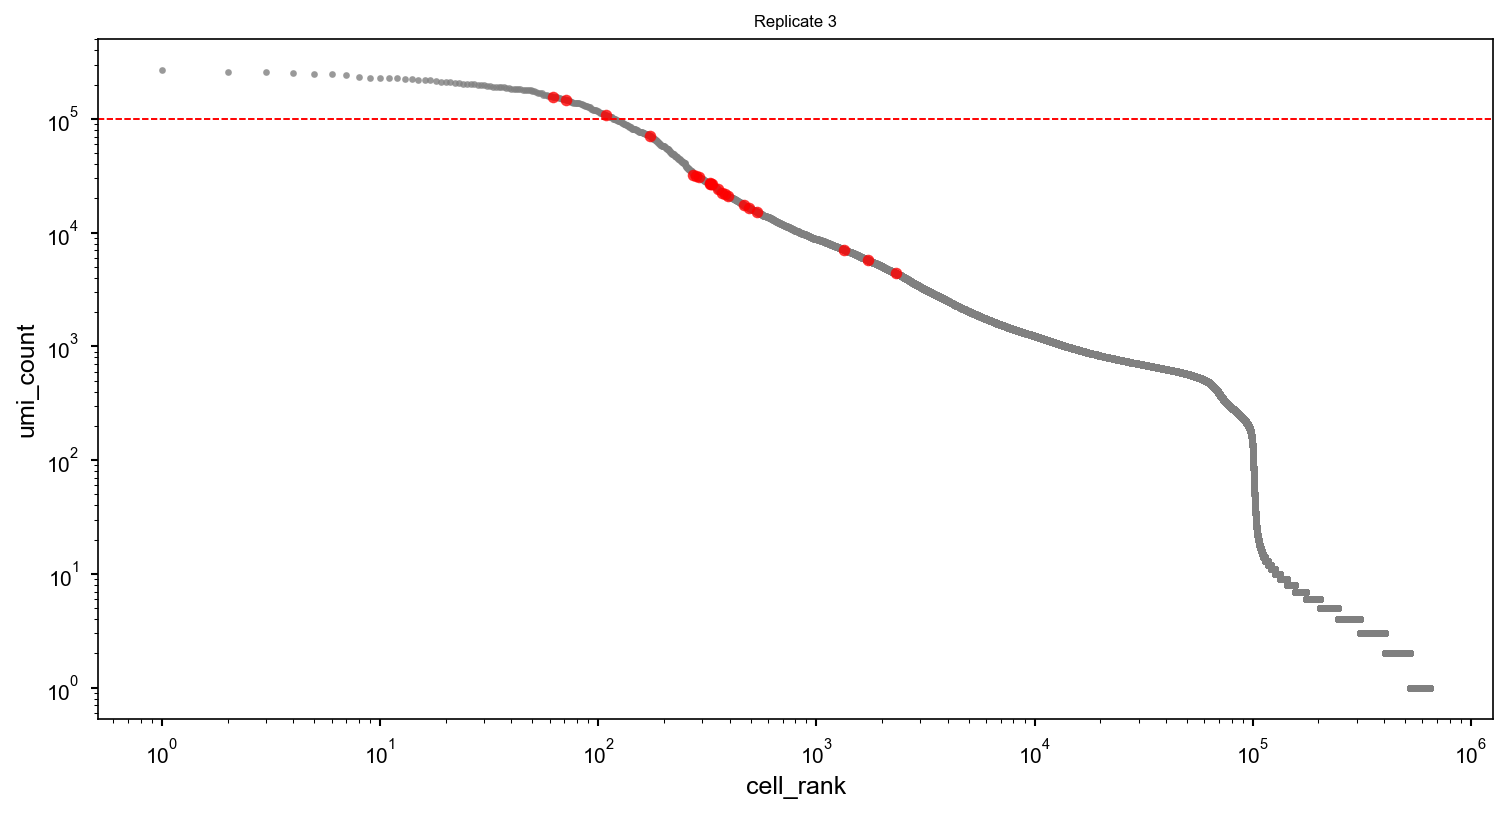

In [189]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis3_force/outs/molecule_info.h5', 'rep3')
plotall(dat, 'Replicate 3')

# vas tj

In [190]:
fbgns = list(map(lambda x: nbconfig.symbol2fbgn[x], ['vas', 'tj']))
_raw = raw.loc[fbgns]
dups = _raw.columns[(_raw.loc[fbgns] > 0).all()].tolist()

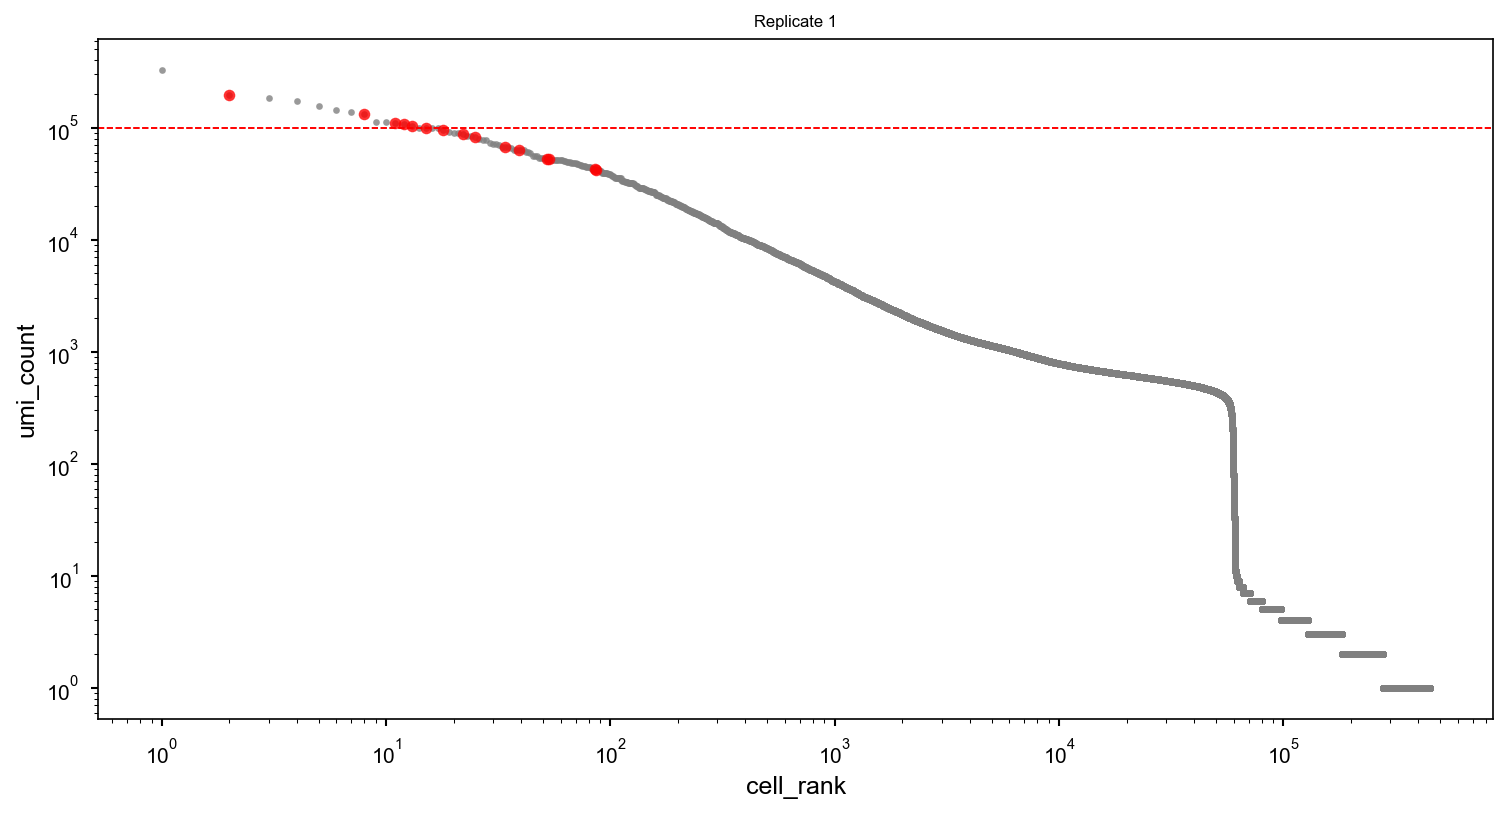

In [191]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis1_force/outs/molecule_info.h5', 'rep1')
plotall(dat, 'Replicate 1')

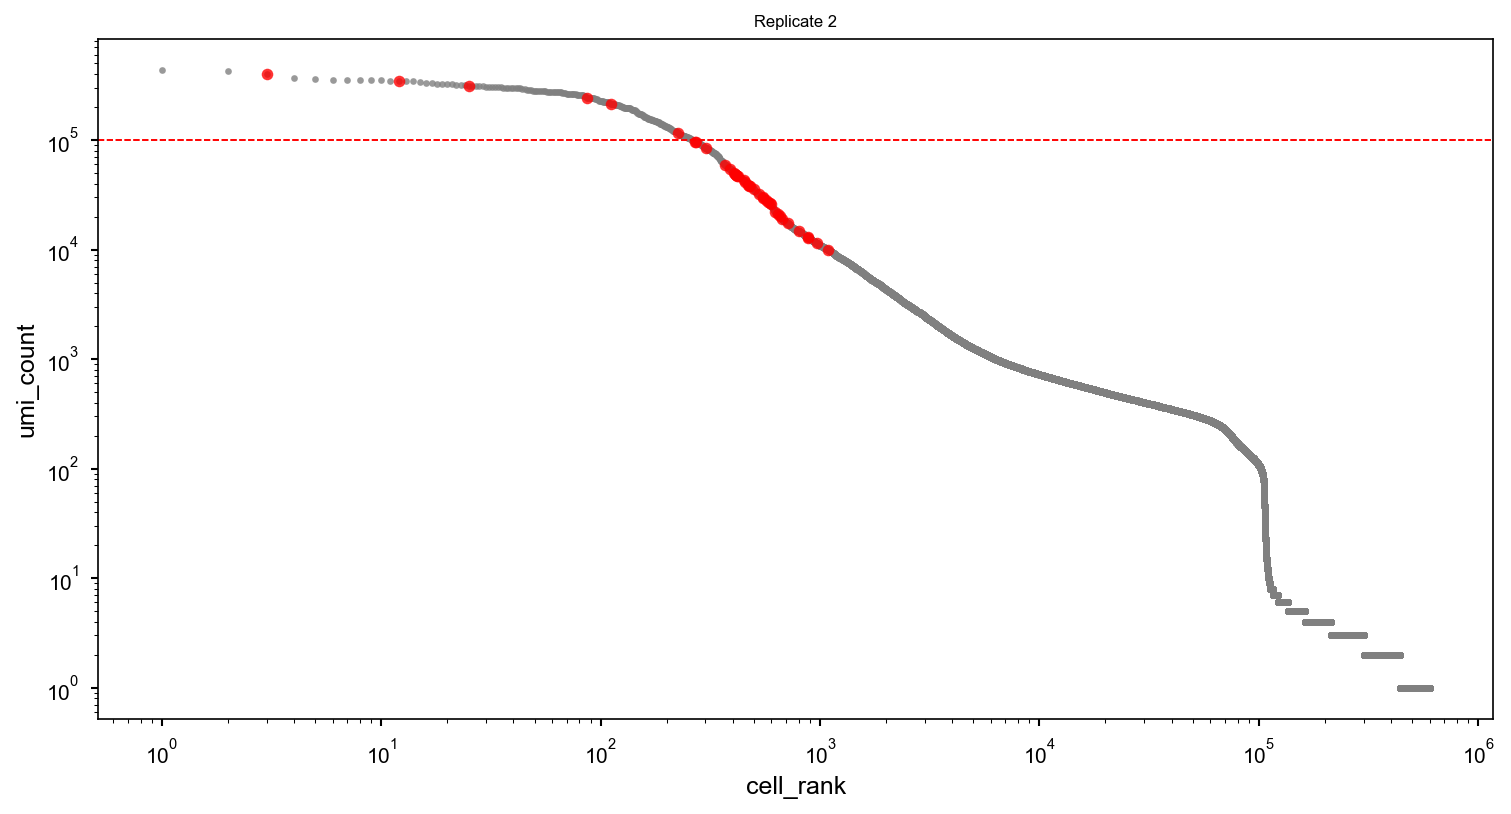

In [192]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis2_force/outs/molecule_info.h5', 'rep2')
plotall(dat, 'Replicate 2')

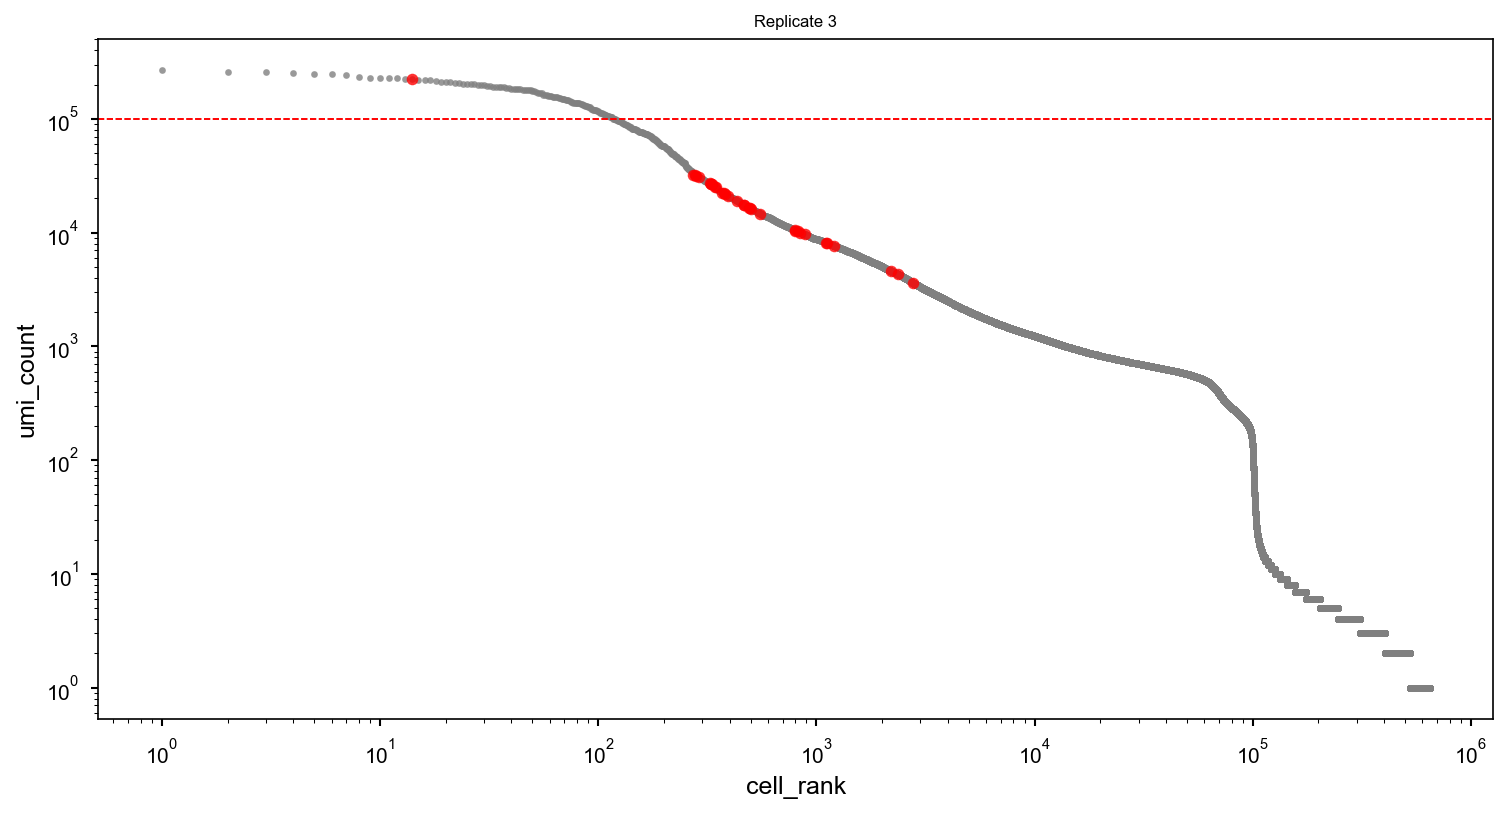

In [193]:
dat = munge('../output/scrnaseq-wf/scrnaseq_samples/testis3_force/outs/molecule_info.h5', 'rep3')
plotall(dat, 'Replicate 3')